In [98]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import fiona
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.plot
import rasterio.shutil
import earthpy as et
import earthpy.plot as ep

In [2]:
%matplotlib inline

In [3]:
# Source data, SRTM & GLIHT
srtm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/srtm/nasa','SRTM30m_Andros.vrt')
glihtdtm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_DTM','Andros_May2015_DTM.vrt')
glihtchm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_CHM','Andros_May2015_CHM.vrt' )
# Working directory
work_dir = '/Users/arbailey/natcap/idb/data/work/andros_mangrovehgt'
os.chdir(work_dir)
print(os.getcwd())
print(srtm_source)

/Users/arbailey/natcap/idb/data/work/andros_mangrovehgt
/Users/arbailey/natcap/idb/data/source/srtm/nasa/SRTM30m_Andros.vrt


In [4]:
glihtdsm_path = os.path.join(work_dir,'Andros_May2015_DSM.tif' )

In [5]:
def get_valid_indices(msked_array):
    # Return tuples of indices for valid (unmasked) values in a masked array
    rows, cols = np.where(~msked_array.mask)
    indices = list(zip(rows, cols))
    return indices

In [6]:
# Get GLiHT into a masked numpy array and store the metadata
with rio.open(glihtdsm_path) as src:
    
    # Read data into masked NumPy array
    glihtdsm_np = src.read(1, masked=True)
    # Cell indices for valid values in the DSM
    indices = get_valid_indices(glihtdsm_np)

    # Raster metadata
    glihtdsm_meta = src.meta
    glihtdsm_bounds = src.bounds # rasterio bounds format
    glihtdsm_spatialextent = rio.plot.plotting_extent(src)# for matplotlib
    
    # example of getting coordinate with an input index
#     (x,y) = src.xy(indices[0][0],indices[0][1])
#     print(x,y)
#     row, col = src.index(x, y)
#     print(row, col)
#     print(glihtdsm_np[row][col])
    
    x_coords = []
    y_coords = []
    vals = []
    # Get x,y coords in projection and associated value
    for row, col in indices:
        x, y = src.xy(row, col)
        #print(x,y)
        val = glihtdsm_np[row][col]
        # print(val)
        x_coords.append(x)
        y_coords.append(y)
        vals.append(val)

    
# print(glihtdsm_np)
# print(glihtdsm_meta)
# print(glihtdsm_meta['transform'])
# print(glihtdsm_meta['nodata'])
# print(glihtdsm_bounds)
# print(glihtdsm_spatialextent)
    


In [7]:
len(indices)

58146871

In [8]:
indices

[(3, 235),
 (4, 231),
 (4, 234),
 (5, 226),
 (5, 228),
 (5, 237),
 (6, 223),
 (6, 230),
 (7, 221),
 (7, 222),
 (7, 224),
 (7, 227),
 (7, 233),
 (7, 241),
 (8, 220),
 (8, 228),
 (8, 231),
 (8, 232),
 (8, 241),
 (8, 243),
 (9, 215),
 (9, 216),
 (9, 218),
 (9, 220),
 (9, 223),
 (9, 228),
 (9, 237),
 (10, 212),
 (10, 213),
 (10, 214),
 (10, 216),
 (10, 217),
 (10, 218),
 (10, 219),
 (10, 220),
 (10, 223),
 (10, 226),
 (10, 229),
 (10, 239),
 (11, 210),
 (11, 211),
 (11, 213),
 (11, 214),
 (11, 215),
 (11, 217),
 (11, 219),
 (11, 221),
 (11, 224),
 (11, 226),
 (11, 237),
 (11, 239),
 (11, 241),
 (12, 208),
 (12, 209),
 (12, 211),
 (12, 212),
 (12, 213),
 (12, 214),
 (12, 216),
 (12, 218),
 (12, 219),
 (12, 222),
 (12, 223),
 (12, 229),
 (12, 231),
 (13, 204),
 (13, 205),
 (13, 206),
 (13, 208),
 (13, 209),
 (13, 210),
 (13, 212),
 (13, 214),
 (13, 215),
 (13, 216),
 (13, 217),
 (13, 219),
 (13, 220),
 (13, 221),
 (13, 223),
 (13, 231),
 (13, 232),
 (13, 233),
 (13, 237),
 (13, 241),
 (13, 2

In [9]:
print(x_coords[0])
print(y_coords[0])
print(vals[0])

788785.5
2787858.5
1.586909


In [18]:
# Create Pandas Data Frame with GLiHT DSM
# The data as a set of parallel lists
glihtdsm_xyz = {
    'dsm_z_m':vals,
    'dsm_x_utm17n': x_coords,
    'dsm_y_utm17n': y_coords
}
glihtdsm_df = pd.DataFrame(glihtdsm_xyz)
glihtdsm_df.head

In [23]:
# Create Geopandas data frame with point locations from Pandas data frame
glihtdsm_gdf = gpd.GeoDataFrame(glihtdsm_df, geometry=gpd.points_from_xy(glihtdsm_df['dsm_x_utm17n'], glihtdsm_df['dsm_y_utm17n']))

In [35]:
# Get CRS from GLiHT DSM and convert it to right format to assign to CRS of GeoData Frame
print(glihtdsm_meta['crs'])
glithdsm_epsg = glihtdsm_meta['crs'].to_epsg()
print(glithdsm_epsg)
print(fiona.crs.from_epsg(glithdsm_epsg))
glihtdsm_gdf.crs = fiona.crs.from_epsg(glithdsm_epsg)
glihtdsm_gdf.crs

EPSG:32617
32617
{'init': 'epsg:32617', 'no_defs': True}


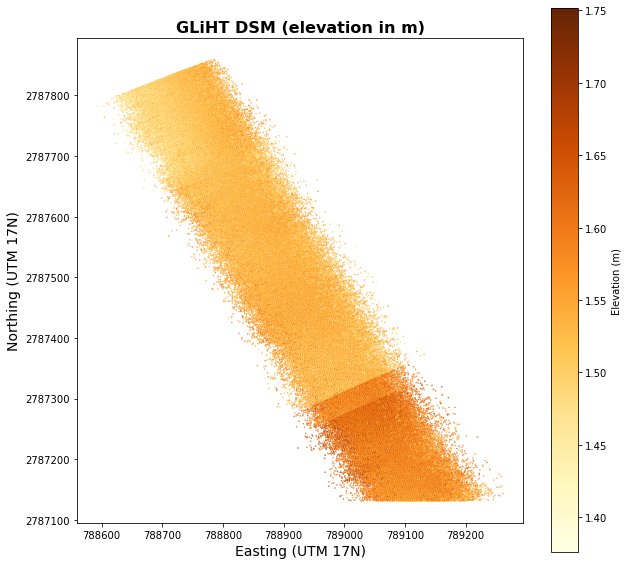

In [109]:
# Plot the GLiHT DSM
glihtdsm_gdf_subset = glihtdsm_gdf.iloc[0:100000]
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title( 'GLiHT DSM (elevation in m)' , fontsize=16, fontweight='bold' )
ax.set_xlabel('Easting (UTM 17N)', fontsize=14)
ax.set_ylabel('Northing (UTM 17N)', fontsize=14)
glihtdsm_gdf_subset.plot(
    column='dsm_z_m', 
    cmap='YlOrBr', 
    markersize=0.2,
    legend=True,
    legend_kwds={'label': "Elevation (m)"},
    ax=ax
)
ax.ticklabel_format(useOffset=False,
                    style='plain')
plt.show()

In [105]:
# Import SRTM Data
srtm = rio.open(srtm_source) # as rasterio dataset
srtm_np_2d_masked = srtm.read(1, masked=True)  # Read to 2D masked NumPy Array
srtm_epsg = srtm.crs.to_epsg()
srtm_epsg

4326

In [106]:
# Reproject GLiHT points to SRTM CRS
glihtdsm_gdf_srtmcrs = glihtdsm_gdf.to_crs(epsg=srtm_epsg)

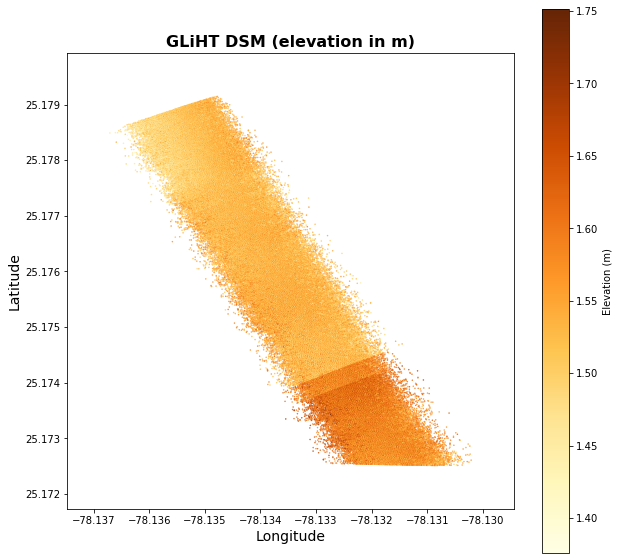

In [110]:
# Plot the GLiHT reprojected DSM
glihtdsm_gdf_srtmcrs_subset = glihtdsm_gdf_srtmcrs.iloc[0:100000]
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title( 'GLiHT DSM (elevation in m)' , fontsize=16, fontweight='bold' )
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
glihtdsm_gdf_srtmcrs_subset.plot(
    column='dsm_z_m', 
    cmap='YlOrBr', 
    markersize=0.2,
    legend=True,
    legend_kwds={'label': "Elevation (m)"},
    ax=ax
)
ax.ticklabel_format(useOffset=False,
                    style='plain')
plt.show()

In [111]:
# Create a raster with unique ID for each SRTM pixel
with rio.open(srtm_source) as src:
    rows, cols = src.shape
    srtm_uniqueid = np.arange(rows * cols).reshape(rows, cols)
srtm_uniqueid

array([[       0,        1,        2, ...,     7198,     7199,     7200],
       [    7201,     7202,     7203, ...,    14399,    14400,    14401],
       [   14402,    14403,    14404, ...,    21600,    21601,    21602],
       ...,
       [77756398, 77756399, 77756400, ..., 77763596, 77763597, 77763598],
       [77763599, 77763600, 77763601, ..., 77770797, 77770798, 77770799],
       [77770800, 77770801, 77770802, ..., 77777998, 77777999, 77778000]])

In [112]:
srtm_np_2d_masked

masked_array(
  data=[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [--, --, --, ..., 0, 0, 0],
        [--, --, --, ..., 0, 0, 0],
        [--, --, --, ..., 0, 0, 0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-32768,
  dtype=int16)

In [113]:
glihtdsm_gdf_srtmcrs.head()

,dsm_z_m,dsm_x_utm17n,dsm_y_utm17n,geometry
0,1.586909,788785.5,2787858.5,POINT (-78.13478 25.17915)
1,1.534521,788781.5,2787857.5,POINT (-78.13482 25.17914)
2,1.539167,788784.5,2787857.5,POINT (-78.13479 25.17914)
3,1.515844,788776.5,2787856.5,POINT (-78.13487 25.17913)
4,1.567966,788778.5,2787856.5,POINT (-78.13485 25.17913)


In [124]:
glihtdsm_gdf_srtmcrs.geometry

0           POINT (-78.13478 25.17915)
1           POINT (-78.13482 25.17914)
2           POINT (-78.13479 25.17914)
3           POINT (-78.13487 25.17913)
4           POINT (-78.13485 25.17913)
                       ...            
58146866    POINT (-78.01828 24.30487)
58146867    POINT (-78.01833 24.30486)
58146868    POINT (-78.01830 24.30485)
58146869    POINT (-78.01828 24.30484)
58146870    POINT (-78.01824 24.30482)
Name: geometry, Length: 58146871, dtype: geometry

In [125]:
glihtdsm_gdf_srtmcrs.geometry.x

0          -78.134777
1          -78.134817
2          -78.134787
3          -78.134867
4          -78.134847
              ...    
58146866   -78.018277
58146867   -78.018326
58146868   -78.018297
58146869   -78.018277
58146870   -78.018238
Length: 58146871, dtype: float64

In [126]:
list(glihtdsm_gdf_srtmcrs.geometry[0].coords)

[(-78.13477705237545, 25.179147458447183)]

In [171]:
def point_coords(geom):
    # Return a tuple with the x/y point coordinate for a GeoDataFrame geometry
    # return list(geom.coords)
    return list(geom.coords)[0] # Just get first tuple in list, since it's a point
glihtdsm_ll = glihtdsm_gdf_srtmcrs.apply(lambda row: point_coords(row.geometry), axis=1)

In [172]:
glihtdsm_ll[0:200]

0      (-78.13477705237545, 25.179147458447183)
1      (-78.13481691073252, 25.179139207145507)
2        (-78.1347871752592, 25.17913863097257)
3      (-78.13486668090961, 25.179131147886178)
4       (-78.13484685726108, 25.17913076377834)
                         ...                   
195    (-78.13516677908076, 25.179019655208403)
196     (-78.13515686726285, 25.17901946317571)
197    (-78.13514695544505, 25.179019271142344)
198     (-78.13513704362734, 25.17901907910832)
199     (-78.13512713180974, 25.17901888707363)
Length: 200, dtype: object

In [173]:
type(glihtdsm_ll)

pandas.core.series.Series

In [174]:
glihtdsm_ll.to_list()

[(-78.13477705237545, 25.179147458447183),
 (-78.13481691073252, 25.179139207145507),
 (-78.1347871752592, 25.17913863097257),
 (-78.13486668090961, 25.179131147886178),
 (-78.13484685726108, 25.17913076377834),
 (-78.1347576508477, 25.179129035260257),
 (-78.13489662743376, 25.179122704508437),
 (-78.13482724466863, 25.179121360133855),
 (-78.13491666213089, 25.179114069074796),
 (-78.13490675030752, 25.179113877024673),
 (-78.13488692666108, 25.179113492922443),
 (-78.13485719119218, 25.17911291676413),
 (-78.13479772025714, 25.17911176442962),
 (-78.13471842568278, 25.1791102279465),
 (-78.13492678500258, 25.179105241589454),
 (-78.13484749042344, 25.179103705175866),
 (-78.13481775495796, 25.17910312900984),
 (-78.13480784313633, 25.179102936953168),
 (-78.13471863674626, 25.17910120841335),
 (-78.13469881310516, 25.179100824286103),
 (-78.1349765551623, 25.179097182291223),
 (-78.13496664333975, 25.179096990245235),
 (-78.13494681969502, 25.179096606151273),
 (-78.13492699605067, 

In [176]:
glihtdsm_ll[0:100]

0     (-78.13477705237545, 25.179147458447183)
1     (-78.13481691073252, 25.179139207145507)
2       (-78.1347871752592, 25.17913863097257)
3     (-78.13486668090961, 25.179131147886178)
4      (-78.13484685726108, 25.17913076377834)
                        ...                   
95    (-78.13499743402114, 25.179052468704242)
96     (-78.13497761038307, 25.17905208461503)
97    (-78.13496769856418, 25.179051892569433)
98      (-78.1349577867454, 25.17905170052317)
99    (-78.13494787492671, 25.179051508476245)
Length: 100, dtype: object

In [201]:
# Subsample TEST
# Sample SRTM raster with the GLiHT points (creates generator)
srtm_subsample_gen = srtm.sample(xy=glihtdsm_ll[0:100])
# Copy source Geodataframe to new one for modification
glihtdsm_srtm_gdf_subsample = glihtdsm_gdf_srtmcrs[0:100].copy()
# Convert generator to a list for appending to geodataframe
srtm_subsample = list(srtm_subsample_gen)
srtm_subsample

[array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], dtype=int16),
 array([0], 

In [202]:
glihtdsm_srtm_gdf = glihtdsm_gdf_srtmcrs
glihtdsm_srtm_gdf.head()

,dsm_z_m,dsm_x_utm17n,dsm_y_utm17n,geometry
0,1.586909,788785.5,2787858.5,POINT (-78.13478 25.17915)
1,1.534521,788781.5,2787857.5,POINT (-78.13482 25.17914)
2,1.539167,788784.5,2787857.5,POINT (-78.13479 25.17914)
3,1.515844,788776.5,2787856.5,POINT (-78.13487 25.17913)
4,1.567966,788778.5,2787856.5,POINT (-78.13485 25.17913)


In [203]:
glihtdsm_srtm_gdf_subsample['srtm_m'] = np.vstack(srtm_subsample)

In [204]:
glihtdsm_srtm_gdf_subsample.head() 

,dsm_z_m,dsm_x_utm17n,dsm_y_utm17n,geometry,srtm_m
0,1.586909,788785.5,2787858.5,POINT (-78.13478 25.17915),0
1,1.534521,788781.5,2787857.5,POINT (-78.13482 25.17914),0
2,1.539167,788784.5,2787857.5,POINT (-78.13479 25.17914),0
3,1.515844,788776.5,2787856.5,POINT (-78.13487 25.17913),0
4,1.567966,788778.5,2787856.5,POINT (-78.13485 25.17913),0


In [205]:
# Sample SRTM raster with the GLiHT points (creates generator)
srtm_sample_gen = srtm.sample(xy=glihtdsm_ll)
# Copy original GLiHT Geodataframe to new one for modification
glihtdsm_srtm_gdf = glihtdsm_gdf_srtmcrs.copy()
# Convert generator to a list for appending to geodataframe
srtm_sample = list(srtm_sample_gen)
# Append sampled SRTM values to Geodataframe
glihtdsm_srtm_gdf['srtm_m'] = np.vstack(srtm_sample)

In [207]:
glihtdsm_srtm_gdf.head()
glihtdsm_srtm_gdf.describe()

,dsm_z_m,dsm_x_utm17n,dsm_y_utm17n,srtm_m
count,5.814687e+07,5.814687e+07,5.814687e+07,5.814687e+07
mean,5.809050e+00,8.087125e+05,2.731477e+06,6.902376e+00
std,5.826881e+00,8.274789e+03,2.413671e+04,4.414268e+00
min,6.346437e-01,7.885925e+05,2.691218e+06,-1.400000e+01
25%,1.728269e+00,8.029605e+05,2.712500e+06,4.000000e+00
50%,2.616798e+00,8.092105e+05,2.727656e+06,6.000000e+00
75%,8.754440e+00,8.157185e+05,2.745886e+06,1.000000e+01
max,3.099091e+01,8.230035e+05,2.787858e+06,4.200000e+01


In [208]:
# export to Geopackage
glihtdsm_srtm_gdf.to_file("gliht_srtm.gpkg", layer='glihtdsm_srtm', driver="GPKG")

In [211]:
# https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # create object for the class
X = glihtdsm_srtm_gdf['srtm_m'].values.reshape(-1, 1)
Y = glihtdsm_srtm_gdf['dsm_z_m'].values.reshape(-1, 1)
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

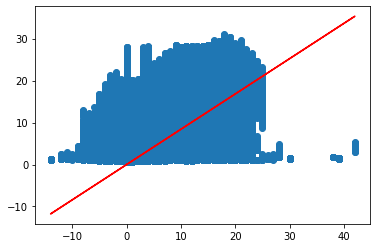

In [212]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [227]:
r_sq = linear_regressor.score(X, Y)
print("R squared:", r_sq)
intercept = linear_regressor.intercept_
print("intercept:", intercept)
slope = linear_regressor.coef_
print("slope:", slope)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true=Y, y_pred=Y_pred))
print("RMSE:", rmse)

R squared: 0.40637937949456515
intercept: [0.00084562]
slope: [[0.84147899]]
RMSE: 4.489424165591314


In [1]:
type(srtm_uniqueid)

NameError: name 'srtm_uniqueid' is not defined